# HDF5 Virtual Dataset Demo

HDF5 Virtual Datasets are a feature of the HDF5 library that allows to create virtual aggregations of datasets by merging the contents of multiple HDF5 files.

Since netCDF4 files are valid HDF5 files, we can reuse this feature to create virtual views of our datasets that are commonly spread between several files.

We are going to see an example using ESGF data. We will download several files from ESGF and then we will generate two virtual datasets with different levels of aggregation, in order to analyze them with xarray and show the advantages of "virtual data analysis ready" datasets.

## Contents

* [Data download](#download)
* [Utitility functions](#utility)
* [Time series aggregation](#time)
* [Variant label aggregation](#variant)
* [Testing everyting is right](#testing)
* [Working with xarray over virtual data analysis ready datasets](#xarray)
* [Virtual dataset with NCO](#nco)
* [Conclusions](#conclusions)

## Data download <a class="anchor" id="download"/>

We are going to download some files from ESGF in order to produce virtual aggregations over real data.

In [1]:
import os
import requests
import tqdm

In [2]:
datasets = [
    # r1i1p1f1, tas and pr, 1850-1869 and 1870-1889
    "http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gn/v20190710/pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc",
    "http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/pr/gn/v20190710/pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_187001-188912.nc",
    "http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gn/v20190710/tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc",
    "http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r1i1p1f1/Amon/tas/gn/v20190710/tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_187001-188912.nc",
    
    # r2i1p1f1, tas and pr, 1850-1869 and 1870-1889
    "http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Amon/pr/gn/v20190710/pr_Amon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn_185001-186912.nc",
    "http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Amon/pr/gn/v20190710/pr_Amon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn_187001-188912.nc",
    "http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Amon/tas/gn/v20190710/tas_Amon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn_185001-186912.nc",
    "http://esgf-data1.llnl.gov/thredds/fileServer/css03_data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r2i1p1f1/Amon/tas/gn/v20190710/tas_Amon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn_187001-188912.nc",
]

for dataset in tqdm.tqdm(datasets):
    filename = dataset.split("/")[-1]
    if not os.path.isfile(filename):
        with requests.get(dataset, stream=True) as r:
            r.raise_for_status()
            with open(filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=8192): 
                    f.write(chunk)

100%|██████████| 8/8 [00:00<00:00, 11598.49it/s]


Let's dump one of the files just to get an idea of the data we are dealing with.

In [3]:
!ncdump -hs tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc

netcdf tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912 {
dimensions:
	time = UNLIMITED ; // (240 currently)
	lat = 96 ;
	lon = 192 ;
	bnds = 2 ;
variables:
	double time(time) ;
		time:bounds = "time_bnds" ;
		time:units = "days since 1850-1-1 00:00:00" ;
		time:calendar = "proleptic_gregorian" ;
		time:axis = "T" ;
		time:long_name = "time" ;
		time:standard_name = "time" ;
		time:_Storage = "chunked" ;
		time:_ChunkSizes = 1 ;
		time:_Endianness = "little" ;
	double time_bnds(time, bnds) ;
		time_bnds:_Storage = "chunked" ;
		time_bnds:_ChunkSizes = 1, 2 ;
		time_bnds:_DeflateLevel = 1 ;
		time_bnds:_Shuffle = "true" ;
		time_bnds:_Endianness = "little" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "contiguous" ;
		lat:_Endianness = "little" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "chunked" ;
		lat_bnds:_ChunkSizes = 96, 2 ;

## Utility functions <a class="anchor" id="utility"/>

In order to create the virtual dataset, we need to extract information from the source files. We are going to generate a Pandas dataframe to store and later query this information.

In [4]:
import os
import re

import pandas as pd
import netCDF4
import h5py

Here we define the function that extracts information from netCDF source files.

In [5]:
def extract(f, drs):
    yield [f, None, None, None, "size", int(os.stat(f).st_size), None, None]
    with netCDF4.Dataset(f) as ds:
        p = re.compile(drs)
        matches = p.search(f)
        for match in matches.groupdict():
            yield [f, match, matches.groupdict()[match], None, None, None, None, None]

        for dimension in ds.dimensions:
            yield [f, None, None, None, None, None, dimension, ds.dimensions[dimension].size]

        for variable in ds.variables:
            yield [f, None, None, variable, "__dtype__", str(ds.variables[variable].dtype), None, None]

            for dimension in ds.variables[variable].dimensions:
                yield [f, None, None, variable, None, None, dimension, ds.dimensions[dimension].size]

Here we define utility functions that will encapsulate functionality required for the creation of the virtual datasets.

In [6]:
NOT_A_VAR = "This is a netCDF dimension but not a netCDF variable.    "

def copy_attrs(src, dest, ignore=None):
    if ignore is None:
        ignore = tuple()

    for attr in src.ncattrs():
        if attr.startswith("_") or (attr in ignore): # ignore this attribute
            continue

        attr_value = src.getncattr(attr)
        if isinstance(attr_value, str):
            l = max(1,len(attr_value)) # control empty strings
            dest.attrs.create(attr, attr_value, dtype="S"+str(l))
        else:
            dest.attrs.create(attr, attr_value, dtype=attr_value.dtype)

def virtual_variable(src, dest, name):
    shape = tuple([src.dimensions[d].size for d in src.dimensions if d in src.variables[name].dimensions])
    layout = h5py.VirtualLayout(
        shape=shape,
        dtype=src.variables[name].dtype)
    vsource = h5py.VirtualSource(src.filepath(), name, shape=shape)
    layout[:] = vsource
    dest.create_virtual_dataset(name, layout)
    copy_attrs(src.variables[name], dest[name])
    
    # is coordinate?
    if len(src.variables[name].dimensions) == 1 and src.variables[name].dimensions[0] == name:
        dest[name].make_scale(name)
    
def create_dimension(group, name, size):
    name_attr = NOT_A_VAR + name
    group.create_dataset(name, size)
    group[name].make_scale(name)
    group[name].attrs.create("NAME", name, dtype="S"+str(len(name_attr)))
    
def variables_shapes(df):
    return df.dropna(axis=0, subset=["filename", "variable", "dimension", "dimension_size"])[["filename", "variable", "dimension", "dimension_size"]]

def variable_shape(df, variable):
    return variables_shapes(df[df["variable"] == variable])

def facets(df):
    facets = df.dropna(axis=0, subset=["facet", "facet_value"])[["filename", "facet", "facet_value"]]
    pivot = facets.pivot("filename", "facet", "facet_value")
    
    return pivot

def varinfo(df, variable):
    return variable_shape(df, variable).merge(facets(df), left_on="filename", right_index=True)

def join_existing(layout, df, dim, outdims=None):
    if outdims is None:
        outdims = list()

    inner_dimensions_df = df[~df["dimension"].isna()][["dimension", "dimension_size"]].drop_duplicates(subset=["dimension"]).iloc[1:]
    inner_dimensions    = dict(zip(inner_dimensions_df["dimension"], inner_dimensions_df["dimension_size"].astype(int)))
    indims    = [slice(0,x,1) for x in list(inner_dimensions.values())]

    counter = 0
    for _,row in df[df["dimension"] == dim].iterrows():
        agg_dim_size = int(row["dimension_size"])
        source_shape = tuple([agg_dim_size] + list(inner_dimensions.values()))
        vsource = h5py.VirtualSource(
            row["filename"],
            row["variable"],
            source_shape)

        if len(outdims) == 0 and len(indims) == 0:
            layout[counter:counter+agg_dim_size] = vsource
        elif len(indims) == 0:
            layout[outdims, counter:counter+agg_dim_size] = vsource
        elif len(outdims) == 0:
            layout[counter:counter+agg_dim_size, :] = vsource
        else:
            layout[outdims, counter:counter+agg_dim_size, :] = vsource

        counter += agg_dim_size
        
# Get layouts for coordinate with bounds
def layout_for_bnds_coord(coord, shape, dtype_coord, dtype_bnds):
    coord_layout = h5py.VirtualLayout(shape=shape, dtype=dtype_coord, maxshape=(None,))
    
    bnds_shape = tuple(list(shape) + [2])
    bnds_layout = h5py.VirtualLayout(shape=bnds_shape, dtype=dtype_bnds, maxshape=(None,2))
    
    return coord_layout, bnds_layout

## Time series aggregation <a class="anchor" id="time"/>

Let's create the "time series aggregation", this consists in a concatenation of files along the existing "time" dimension. Also, the union of multiple climate variables, "pr" and "tas" in this case, is performed.

Now that we have defined our read function, we generate our DataFrame from the netCDF source files that we have downloaded.

In [7]:
sources = [os.path.basename(x) for x in datasets if "r1i1p1f1" in x]
DRS = "(?P<DRS_variableid>[^_]+)_Amon_MPI-ESM1-2-LR_historical_(?P<DRS_variant_label>[^_]+)_gn_(?P<DRS_from>[0-9]+)-(?P<DRS_to>[0-9]+)\.nc"
columns = ["filename", "facet", "facet_value", "variable", "attr", "attr_value", "dimension", "dimension_size"]

df = pd.DataFrame([row for source in sources for row in extract(source, DRS)], columns=columns)

The DataFrame provides us with the necessary information (dimensions, dimension sizes, variable names, etc.) that we need to create the aggregation or virtual dataset.

In [8]:
df

,filename,facet,facet_value,variable,attr,attr_value,dimension,dimension_size
0,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,None,None,None,size,13261604,None,NaN
1,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,DRS_variableid,pr,None,None,None,None,NaN
2,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,DRS_variant_label,r1i1p1f1,None,None,None,None,NaN
3,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,DRS_from,185001,None,None,None,None,NaN
4,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,DRS_to,186912,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...
109,tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_...,None,None,height,__dtype__,float64,None,NaN
110,tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_...,None,None,tas,__dtype__,float32,None,NaN
111,tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_...,None,None,tas,None,None,time,240.0
112,tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_...,None,None,tas,None,None,lat,96.0


Let's perform the actual creation of the virtual dataset.

In [9]:
fname = "timeseries_aggregation.h5"

with h5py.File(fname, "w") as f:
    aggregation_variables = df[df["facet"] == "DRS_variableid"]["facet_value"].dropna().unique()

    # choose a prototype file
    prototype = netCDF4.Dataset(df["filename"].dropna().iloc[0])

    # set bounds dimension
    create_dimension(f, "bnds", 2)

    # generate "static" virtual variables
    for variable in ["lat", "lat_bnds", "lon", "lon_bnds"]:
        virtual_variable(prototype, f, variable)

    # generate the join existing coordinates
    time_len = int(varinfo(df, "time").drop_duplicates("DRS_from")["dimension_size"].sum())
    layout_time, layout_bnds = layout_for_bnds_coord(
        "time",
        (time_len,),
        df[(df["variable"] == "time") & (df["attr"] == "__dtype__")]["attr_value"].iloc[0],
        df[(df["variable"] == "time_bnds") & (df["attr"] == "__dtype__")]["attr_value"].iloc[0])

    join_existing(
        layout_time, 
        varinfo(df, "time").drop_duplicates(["dimension", "DRS_from"]),
        "time")

    join_existing(
        layout_bnds,
        varinfo(df, "time_bnds").drop_duplicates(["dimension", "DRS_from"]),
        "time")

    f.create_virtual_dataset("time",layout_time)
    f.create_virtual_dataset("time_bnds",layout_bnds)
    f["time"].make_scale("time")

    # generate aggregated variables, along with coordinates
    for variable in aggregation_variables:
        vdf = variable_shape(df, "tas").merge(facets(df), left_on="filename", right_index=True)
        variable_prototype = netCDF4.Dataset(df[(df["facet"] == "DRS_variableid") & (df["facet_value"] == variable)]["filename"].iloc[0])

        # create the virtual layout
        layout = h5py.VirtualLayout(
            shape=tuple(
                [vdf[vdf["dimension"] == "time"].drop_duplicates("DRS_from")["dimension_size"].sum()] + # time
                list(vdf[["dimension", "dimension_size"]].drop_duplicates(subset="dimension").iloc[1:]["dimension_size"])), # lat lon
            dtype=variable_prototype.variables[variable].dtype)

        join_existing(
            layout,
            varinfo(df, variable),
            "time")

        # create virtual variable
        dset = f.create_virtual_dataset(variable,layout)
        copy_attrs(variable_prototype.variables[variable], dset)
        copy_attrs(variable_prototype.variables["time"], f["time"])
        copy_attrs(variable_prototype.variables["time_bnds"], f["time_bnds"])

        # dimension scales
        dset.dims[0].attach_scale(f["time"])
        dset.dims[1].attach_scale(f["lat"])
        dset.dims[2].attach_scale(f["lon"])

        # close
        variable_prototype.close()

    prototype.close()

We check that the creation of the virtual dataset does not incur in additional storage usage.

In [10]:
size = os.stat(fname).st_size
print("Virtual dataset size: {} bytes (~ {} KiB).".format(size, size // 1024))

Virtual dataset size: 11880 bytes (~ 11 KiB).


Next we perform a `ncdump` of the virtual dataset. This shows how netCDF tools can be used with HDF5 Virtual Datasets.

In [11]:
!ncdump -hs timeseries_aggregation.h5

netcdf timeseries_aggregation {
dimensions:
	bnds = 2 ;
	lat = 96 ;
	lon = 192 ;
	time = UNLIMITED ; // (480 currently)
variables:
	float bnds(bnds) ;
		bnds:_Storage = "contiguous" ;
		bnds:_Endianness = "little" ;
		bnds:_NoFill = "true" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "unknown" ;
		lat:_Endianness = "little" ;
		lat:_NoFill = "true" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "unknown" ;
		lat_bnds:_Endianness = "little" ;
		lat_bnds:_NoFill = "true" ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:_Storage = "unknown" ;
		lon:_Endianness = "little" ;
		lon:_NoFill = "true" ;
	double lon_bnds(lon, bnds) ;
		lon_bnds:_Storage = "unknown" ;
		lon_bnds:_Endianness = "little" ;
		lon_bnds:_NoFill = "true" ;

## Variant label aggregation <a class="anchor" id="variant"/>

Let's create the "variant label aggregation". This consists in a concatenation of files along the existing "time" dimension, plus the union of multiple climate variables, "pr" and "tas" just like in the previous aggregation. However, a new coordinate dimension "variant label" is added to the virtual dataset and the climate variables are added this new dimension thus transforming them from three dimensional to four dimensional datasets.

In [12]:
sources = [os.path.basename(x) for x in datasets]

DRS = "(?P<DRS_variableid>[^_]+)_Amon_MPI-ESM1-2-LR_historical_(?P<DRS_variant_label>[^_]+)_gn_(?P<DRS_from>[0-9]+)-(?P<DRS_to>[0-9]+)\.nc"
columns = ["filename", "facet", "facet_value", "variable", "attr", "attr_value", "dimension", "dimension_size"]

df = pd.DataFrame([row for source in sources for row in extract(source, DRS)], columns=columns)

In [13]:
df

,filename,facet,facet_value,variable,attr,attr_value,dimension,dimension_size
0,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,None,None,None,size,13261604,None,NaN
1,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,DRS_variableid,pr,None,None,None,None,NaN
2,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,DRS_variant_label,r1i1p1f1,None,None,None,None,NaN
3,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,DRS_from,185001,None,None,None,None,NaN
4,pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_1...,DRS_to,186912,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...
223,tas_Amon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn_...,None,None,height,__dtype__,float64,None,NaN
224,tas_Amon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn_...,None,None,tas,__dtype__,float32,None,NaN
225,tas_Amon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn_...,None,None,tas,None,None,time,240.0
226,tas_Amon_MPI-ESM1-2-LR_historical_r2i1p1f1_gn_...,None,None,tas,None,None,lat,96.0


Create the virtual dataset.

In [14]:
fname = "ensemble_aggregation.h5"

with h5py.File(fname, "w") as f:
    aggregation_variables = df[df["facet"] == "DRS_variableid"]["facet_value"].dropna().unique()

    # variant_labels is now a dataset and netCDF coordinate
    variant_labels = df[df["facet"] == "DRS_variant_label"]["facet_value"].dropna().unique()
    variant_label_dset = f.create_dataset(
        "variant_label",
        len(variant_labels),
        dtype=h5py.string_dtype("utf-8", None),
        chunks=True,
        compression="gzip")
    variant_label_dset.attrs.create("_CoordinateAxisType", "Ensemble")
    variant_label_dset.attrs.create("standard_name", "realization")
    variant_label_dset.make_scale(variant_label_dset.name)
    variant_label_dset[:] = list(variant_labels)

    # choose a prototype file
    prototype = netCDF4.Dataset(df["filename"].dropna().iloc[0])

    # set bounds dimension
    create_dimension(f, "bnds", 2)

    # generate "static" virtual variables
    for variable in ["lat", "lat_bnds", "lon", "lon_bnds"]:
        virtual_variable(prototype, f, variable)

    # generate the join existing coordinates
    time_len = int(varinfo(df, "time").drop_duplicates("DRS_from")["dimension_size"].sum())
    layout_time, layout_bnds = layout_for_bnds_coord(
        "time",
        (time_len,),
        df[(df["variable"] == "time") & (df["attr"] == "__dtype__")]["attr_value"].iloc[0],
        df[(df["variable"] == "time_bnds") & (df["attr"] == "__dtype__")]["attr_value"].iloc[0])

    join_existing(
        layout_time, 
        varinfo(df, "time").drop_duplicates(["dimension", "DRS_from"]),
        "time")

    join_existing(
        layout_bnds,
        varinfo(df, "time_bnds").drop_duplicates(["dimension", "DRS_from"]),
        "time")

    f.create_virtual_dataset("time",layout_time)
    f.create_virtual_dataset("time_bnds",layout_bnds)
    f["time"].make_scale("time")

    # generate aggregated variables, along with coordinates
    for variable in aggregation_variables:
        vdf = variable_shape(df, "tas").merge(facets(df), left_on="filename", right_index=True)
        variable_prototype = netCDF4.Dataset(df[(df["facet"] == "DRS_variableid") & (df["facet_value"] == variable)]["filename"].iloc[0])

        # create the virtual layout
        layout = h5py.VirtualLayout(
            shape=tuple(
                [len(variant_labels)] + # variant_label
                [vdf[vdf["dimension"] == "time"].drop_duplicates("DRS_from")["dimension_size"].sum()] + # time
                list(vdf[["dimension", "dimension_size"]].drop_duplicates(
                    subset="dimension").iloc[1:]["dimension_size"])), # lat lon
            dtype=variable_prototype.variables[variable].dtype)

        # fill virtual layout
        for i,variant_label in enumerate(variant_labels):
            join_existing(
                layout,
                varinfo(df, variable).query('(DRS_variant_label == "{}")'.format(variant_label)),
                "time",
                outdims=[i])

        # create virtual variable
        dset = f.create_virtual_dataset(variable, layout, fillvalue=variable_prototype.variables[variable]._FillValue)
        copy_attrs(variable_prototype.variables[variable], dset)
        copy_attrs(variable_prototype.variables["time"], f["time"])
        copy_attrs(variable_prototype.variables["time_bnds"], f["time_bnds"])

        # dimension scales
        dset.dims[0].attach_scale(f["variant_label"])
        dset.dims[1].attach_scale(f["time"])
        dset.dims[2].attach_scale(f["lat"])
        dset.dims[3].attach_scale(f["lon"])

        # close
        variable_prototype.close()

    prototype.close()

Verify that the virtual dataset does not incur in additional storage usage.

In [15]:
size = os.stat(fname).st_size
print("Virtual dataset size: {} bytes (~ {} KiB).".format(size, size // 1024))

Virtual dataset size: 15279 bytes (~ 14 KiB).


View the contents of the virtual dataset via `ncdump`.

In [16]:
!ncdump -hs ensemble_aggregation.h5

netcdf ensemble_aggregation {
dimensions:
	bnds = 2 ;
	lat = 96 ;
	lon = 192 ;
	time = UNLIMITED ; // (480 currently)
	variant_label = 2 ;
variables:
	float bnds(bnds) ;
		bnds:_Storage = "contiguous" ;
		bnds:_Endianness = "little" ;
		bnds:_NoFill = "true" ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:_Storage = "unknown" ;
		lat:_Endianness = "little" ;
		lat:_NoFill = "true" ;
	double lat_bnds(lat, bnds) ;
		lat_bnds:_Storage = "unknown" ;
		lat_bnds:_Endianness = "little" ;
		lat_bnds:_NoFill = "true" ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:_Storage = "unknown" ;
		lon:_Endianness = "little" ;
		lon:_NoFill = "true" ;
	double lon_bnds(lon, bnds) ;
		lon_bnds:_Storage = "unknown" ;
		lon_bnds:_Endianness = "little" ;
		lon_bnds

## Testing everyting is right <a class="anchor" id="testing"/>

Creation of virtual datasets consist under the hood in a form of scientific ETL (Extract Transform Load) process in which data loss might easily occur. Because of this, it's useful to implement a verification step in which we ensure that the contents of the virtual dataset match the virtual sources. Let's define a test function that will ensure that the virtual datasets generation process has performed succesfully by comparing the contents of the virtual dataset with the original files.

In [17]:
import xarray

def test(reference, test):
    reference_mean = reference.mean().values.item()
    test_mean      = test.mean().values.item()
    
    return reference_mean == test_mean

### Test timeseries_aggregation.h5

In [18]:
ds = xarray.open_dataset("timeseries_aggregation.h5")

with xarray.open_dataset("tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc") as reference:
    print(test(reference["tas"], ds["tas"].sel(time=slice("18500101", "18691231"))))

with xarray.open_dataset("tas_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_187001-188912.nc") as reference:
    print(test(reference["tas"], ds["tas"].sel(time=slice("18700101", "18891231"))))
    
with xarray.open_dataset("pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_185001-186912.nc") as reference:
    print(test(reference["pr"], ds["pr"].sel(time=slice("18500101", "18691231"))))

with xarray.open_dataset("pr_Amon_MPI-ESM1-2-LR_historical_r1i1p1f1_gn_187001-188912.nc") as reference:
    print(test(reference["pr"], ds["pr"].sel(time=slice("18700101", "18891231"))))
    
ds.close()

True
True
True
True


### Test ensemble_aggregation.h5

In [19]:
ds = xarray.open_dataset("ensemble_aggregation.h5")

for vl in ["r1i1p1f1", "r2i1p1f1"]:
    with xarray.open_dataset(f"tas_Amon_MPI-ESM1-2-LR_historical_{vl}_gn_185001-186912.nc") as reference:
        print(test(reference["tas"], ds["tas"].sel(time=slice("18500101", "18691231"), variant_label=vl)))

    with xarray.open_dataset(f"tas_Amon_MPI-ESM1-2-LR_historical_{vl}_gn_187001-188912.nc") as reference:
        print(test(reference["tas"], ds["tas"].sel(time=slice("18700101", "18891231"), variant_label=vl)))

    with xarray.open_dataset(f"pr_Amon_MPI-ESM1-2-LR_historical_{vl}_gn_185001-186912.nc") as reference:
        print(test(reference["pr"], ds["pr"].sel(time=slice("18500101", "18691231"), variant_label=vl)))

    with xarray.open_dataset(f"pr_Amon_MPI-ESM1-2-LR_historical_{vl}_gn_187001-188912.nc") as reference:
        print(test(reference["pr"], ds["pr"].sel(time=slice("18700101", "18891231"), variant_label=vl)))
        
ds.close()

True
True
True
True
True
True
True
True


## Working with xarray over virtual data analysis ready datasets <a class="anchor" id="xarray"/>

Xarray introduces labels in the form of dimensions, coordinates and attributes on top of raw NumPy-like arrays, which allows for a more intuitive, more concise, and less error-prone developer experience.

We are going to use xarray to perform examination of the generated virtual datasets.

In [20]:
import xarray
import matplotlib.pyplot as plt

### Examination of the virtual "time series" aggregation dataset

In [21]:
ds = xarray.open_dataset("timeseries_aggregation.h5")

In [22]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 96, lon: 192, time: 480)
Coordinates:
  * bnds       (bnds) float32 0.0 0.0
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1889-12-16T12:00:00
Data variables:
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    pr         (time, lat, lon) float32 ...
    tas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) datetime64[ns] ...

Let's perform a simple plot using xarray.

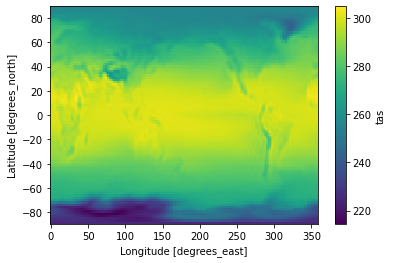

In [23]:
ds["tas"].sel(time=slice("18500101", "18691231")).mean(["time"]).plot()

In [24]:
ds.close()

### Examination of the virtual "variant label" aggregation dataset

In [25]:
ds = xarray.open_dataset("ensemble_aggregation.h5")

In [26]:
ds

<xarray.Dataset>
Dimensions:        (bnds: 2, lat: 96, lon: 192, variant_label: 2, time: 480)
Coordinates:
  * bnds           (bnds) float32 0.0 0.0
  * lat            (lat) float64 -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * lon            (lon) float64 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time           (time) datetime64[ns] 1850-01-16T12:00:00 ... 1889-12-16T1...
  * variant_label  (variant_label) object 'r1i1p1f1' 'r2i1p1f1'
Data variables:
    lat_bnds       (lat, bnds) float64 ...
    lon_bnds       (lon, bnds) float64 ...
    pr             (variant_label, time, lat, lon) float32 ...
    tas            (variant_label, time, lat, lon) float32 ...
    time_bnds      (time, bnds) datetime64[ns] ...

Now let's see how easy is to perform multidimensional analysis on climate ready datasets over multiple dimensions. Semantic information about the dimensions is provided by xarray.

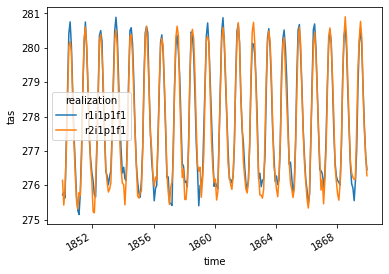

In [27]:
ds["tas"].sel(time=slice("18500101", "18691231")).mean(["lat", "lon"]).plot.line(x="time")

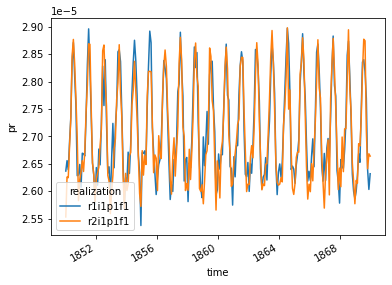

In [28]:
ds["pr"].sel(time=slice("18500101", "18691231")).mean(["lat", "lon"]).plot.line(x="time")

In [29]:
ds.close()

## Virtual dataset with NCO <a class="anchor" id="nco"/>

Virtual datasets should be transparent to netCDF clients. However, in practice and due to implementations details, netCDF clients might fail when dealing with HDF5 Virtual Datasets. Here we show how we can use a NCO operator to perform a record average in the variable aggregation virtual dataset.

In [30]:
!ncra -3 -O timeseries_aggregation.h5 average.nc

In [31]:
!ncdump -hs average.nc

netcdf average {
dimensions:
	bnds = 2 ;
	lat = 96 ;
	lon = 192 ;
	time = UNLIMITED ; // (1 currently)
variables:
	float bnds(bnds) ;
	double lat(lat) ;
		lat:bounds = "lat_bnds" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
	double lat_bnds(lat, bnds) ;
	double lon(lon) ;
		lon:bounds = "lon_bnds" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
	double lon_bnds(lon, bnds) ;
	float pr(time, lat, lon) ;
		pr:standard_name = "precipitation_flux" ;
		pr:long_name = "Precipitation" ;
		pr:comment = "includes both liquid and solid phases" ;
		pr:units = "kg m-2 s-1" ;
		pr:original_name = "pr" ;
		pr:cell_methods = "area: time: mean" ;
		pr:cell_measures = "area: areacella" ;
		pr:history = "2019-09-11T14:13:17Z altered by CMOR: replaced missing value flag (-9e+33) and corresponding data with standard missing value (1e+20). 2019-09-11T14:13:18Z alt

## Conclusions  <a class="anchor" id="conclusions"/>

- HDF5 Virtual Dataset (VDS) is a powerful feature that allows to create compound virtual views of existing datasets without requiring additional storage capacity.
- Since netCDF4, netCDF datasets are also HDF5 files. Thus, netCDF applications (xarray, nco, cdo) may also benefit from the VDS feature.
- Data analysis ready datasets facilitate and optimize end user data analysis workflows.
- Creation of Virtual Datasets is a form of ETL (Extract Transform Load) process.
- netCDF client libraries may find issues when opening virtual datasets (e.g. nccopy, due to “storage mode” unknown).